# Title: California Housing price prediction


- Problem Statement: predict price of the house
- Type: Regression
- Success Metric: R2 Score, RMSE


## Enviroment Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import *

import warnings
warnings.filterwarnings('ignore')

## Data loading


In [2]:
df_og = pd.read_csv("../datasets/california_housing.csv")
df_og.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea


In [3]:
df_og.shape

(20640, 10)

our data has 10 features and 20,640 rows, median_house_value is our target columns


## Data understanding


### Basic info


In [4]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


we have 1 categorical column and 9 numeric features, our target feature is numeric


In [5]:
df_og.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

we will handle this value in data preprocessing


### Statistical inference


In [6]:
df_og.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


- the minimum median age of our house is 1, meaning there are new buildings in every area and a 75% of age 37 shows that there are old buildings in majority of the areas as well.
- every house has minimum 2 total rooms and 1 bedroom.
- there are areas with only 3 people living in them and also ones which have 35682 people living in them but most have 800 to 1700 people.
- there are mostly 280 to 605 households in each area.
- most of the houses have a total income of 25k to 47k USD.
- nost houses cost 15k to 26k USD.


### Visuals


In [7]:
def visualise(df: pd.DataFrame):
    categorical_columns = df.select_dtypes(include="object").columns
    numerical_columns = df.select_dtypes(include="number").columns

    if len(categorical_columns) > 0:
        n_cols = 3
        n_rows = math.ceil(len(categorical_columns) / n_cols)

        plt.figure(figsize=(5 * n_cols, 5 * n_rows))
        for i, col in enumerate(categorical_columns, 1):
            plt.subplot(n_rows, n_cols, i)
            values = df[col].value_counts()
            top = values.head(5)
            if len(values) > 5:
                top['others'] = values[5:].sum()
            plt.pie(top, labels=top.index, autopct="%1.1f%%", startangle=90)
            plt.title(f"Distribution of {col}")

        plt.suptitle("Categorical Columns - Pie chart", fontsize = 16)
        plt.tight_layout()
        plt.show()

    if len(numerical_columns) > 0:
        n_cols = 3
        n_rows = math.ceil(len(numerical_columns) / n_cols)
        plt.figure(figsize=(5 * n_cols, 5 * n_rows))

        for i, col in enumerate(numerical_columns, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.boxplot(df[col].dropna())
            plt.title(f"Boxplot of {col}")
            plt.ylabel(col)

        plt.suptitle("Numerical columns - Boxplot", fontsize = 16)
        plt.tight_layout()
        plt.show()

    if len(numerical_columns) > 0:
        n_cols = 3
        n_rows = math.ceil(len(numerical_columns) / n_cols)
        plt.figure(figsize=(5 * n_cols, 5 * n_rows))

        for i, col in enumerate(numerical_columns, 1):
            plt.subplot(n_rows, n_cols, i)
            mean = df[col].mean()
            plt.axvline(mean, color="r", linestyle="dashed", linewidth=1)
            sns.histplot(df[col].dropna(), kde=True, bins = 30)
            plt.title(f"Histplot of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")

        plt.suptitle("Numerical columns - Histplot", fontsize=16)
        plt.tight_layout()
        plt.show()

    if len(numerical_columns) > 1:
        pair = sns.pairplot(df[numerical_columns])
        pair.figure.suptitle("Numeric features multivariate analysis using pairplot", y=1.02)
        plt.show()

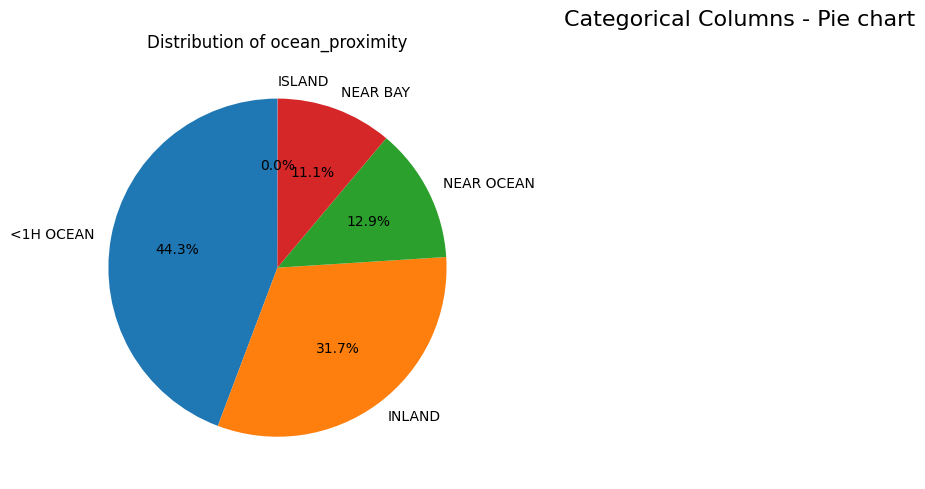

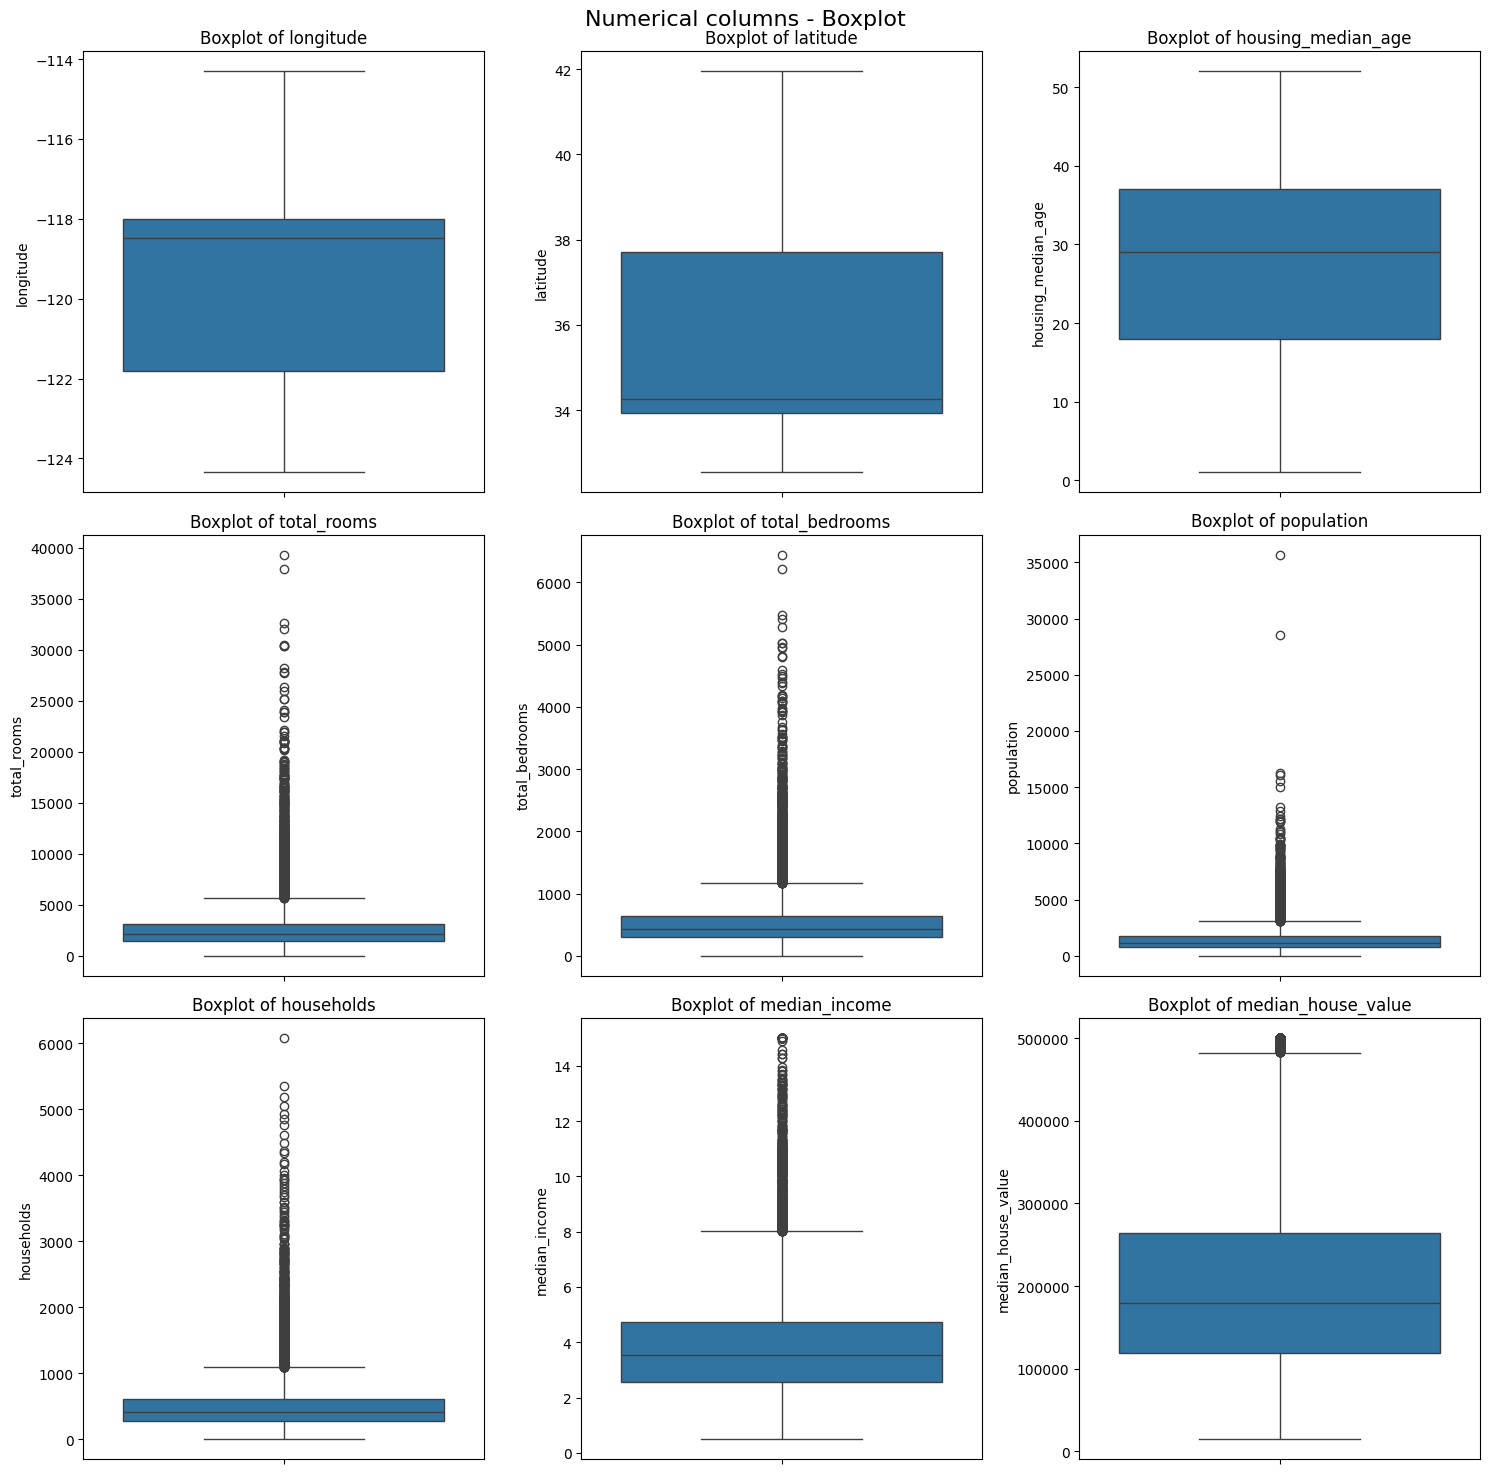

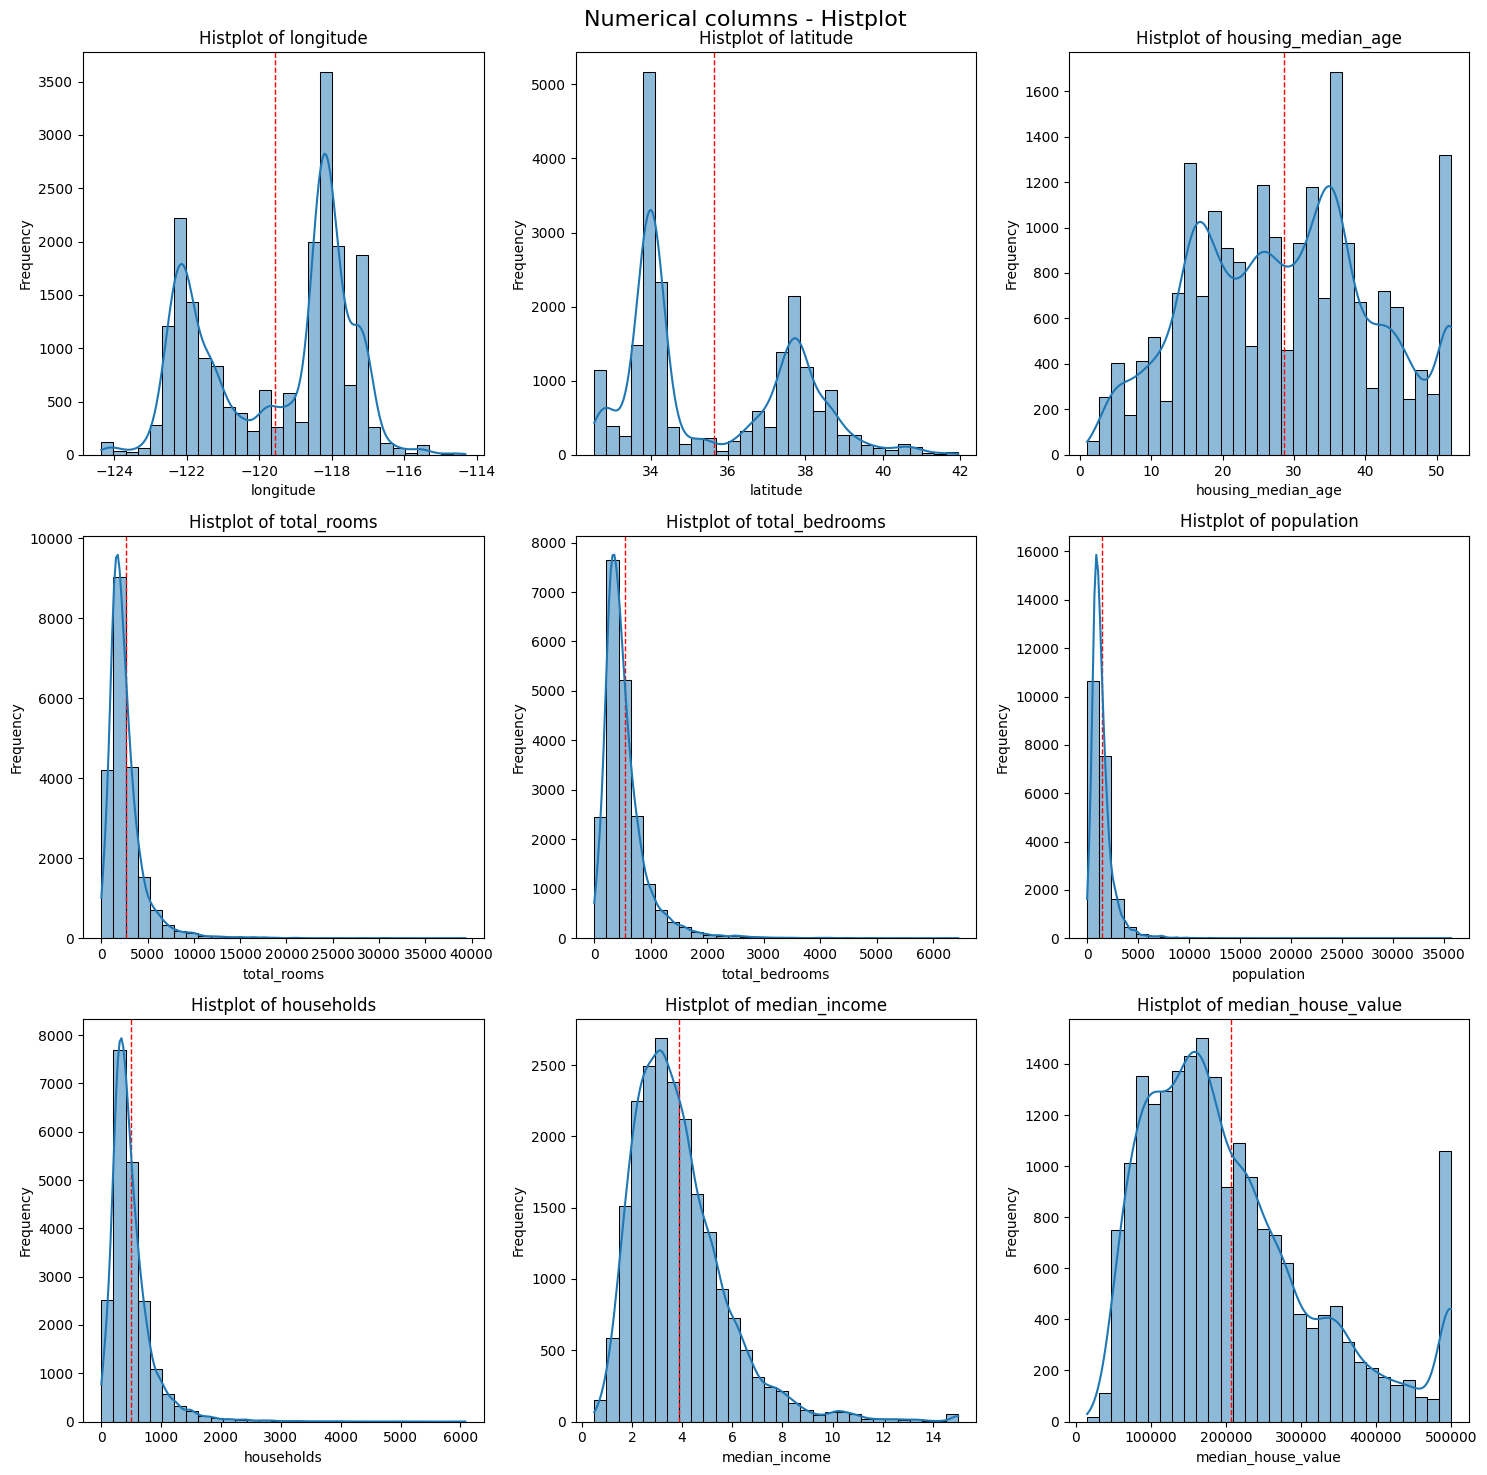

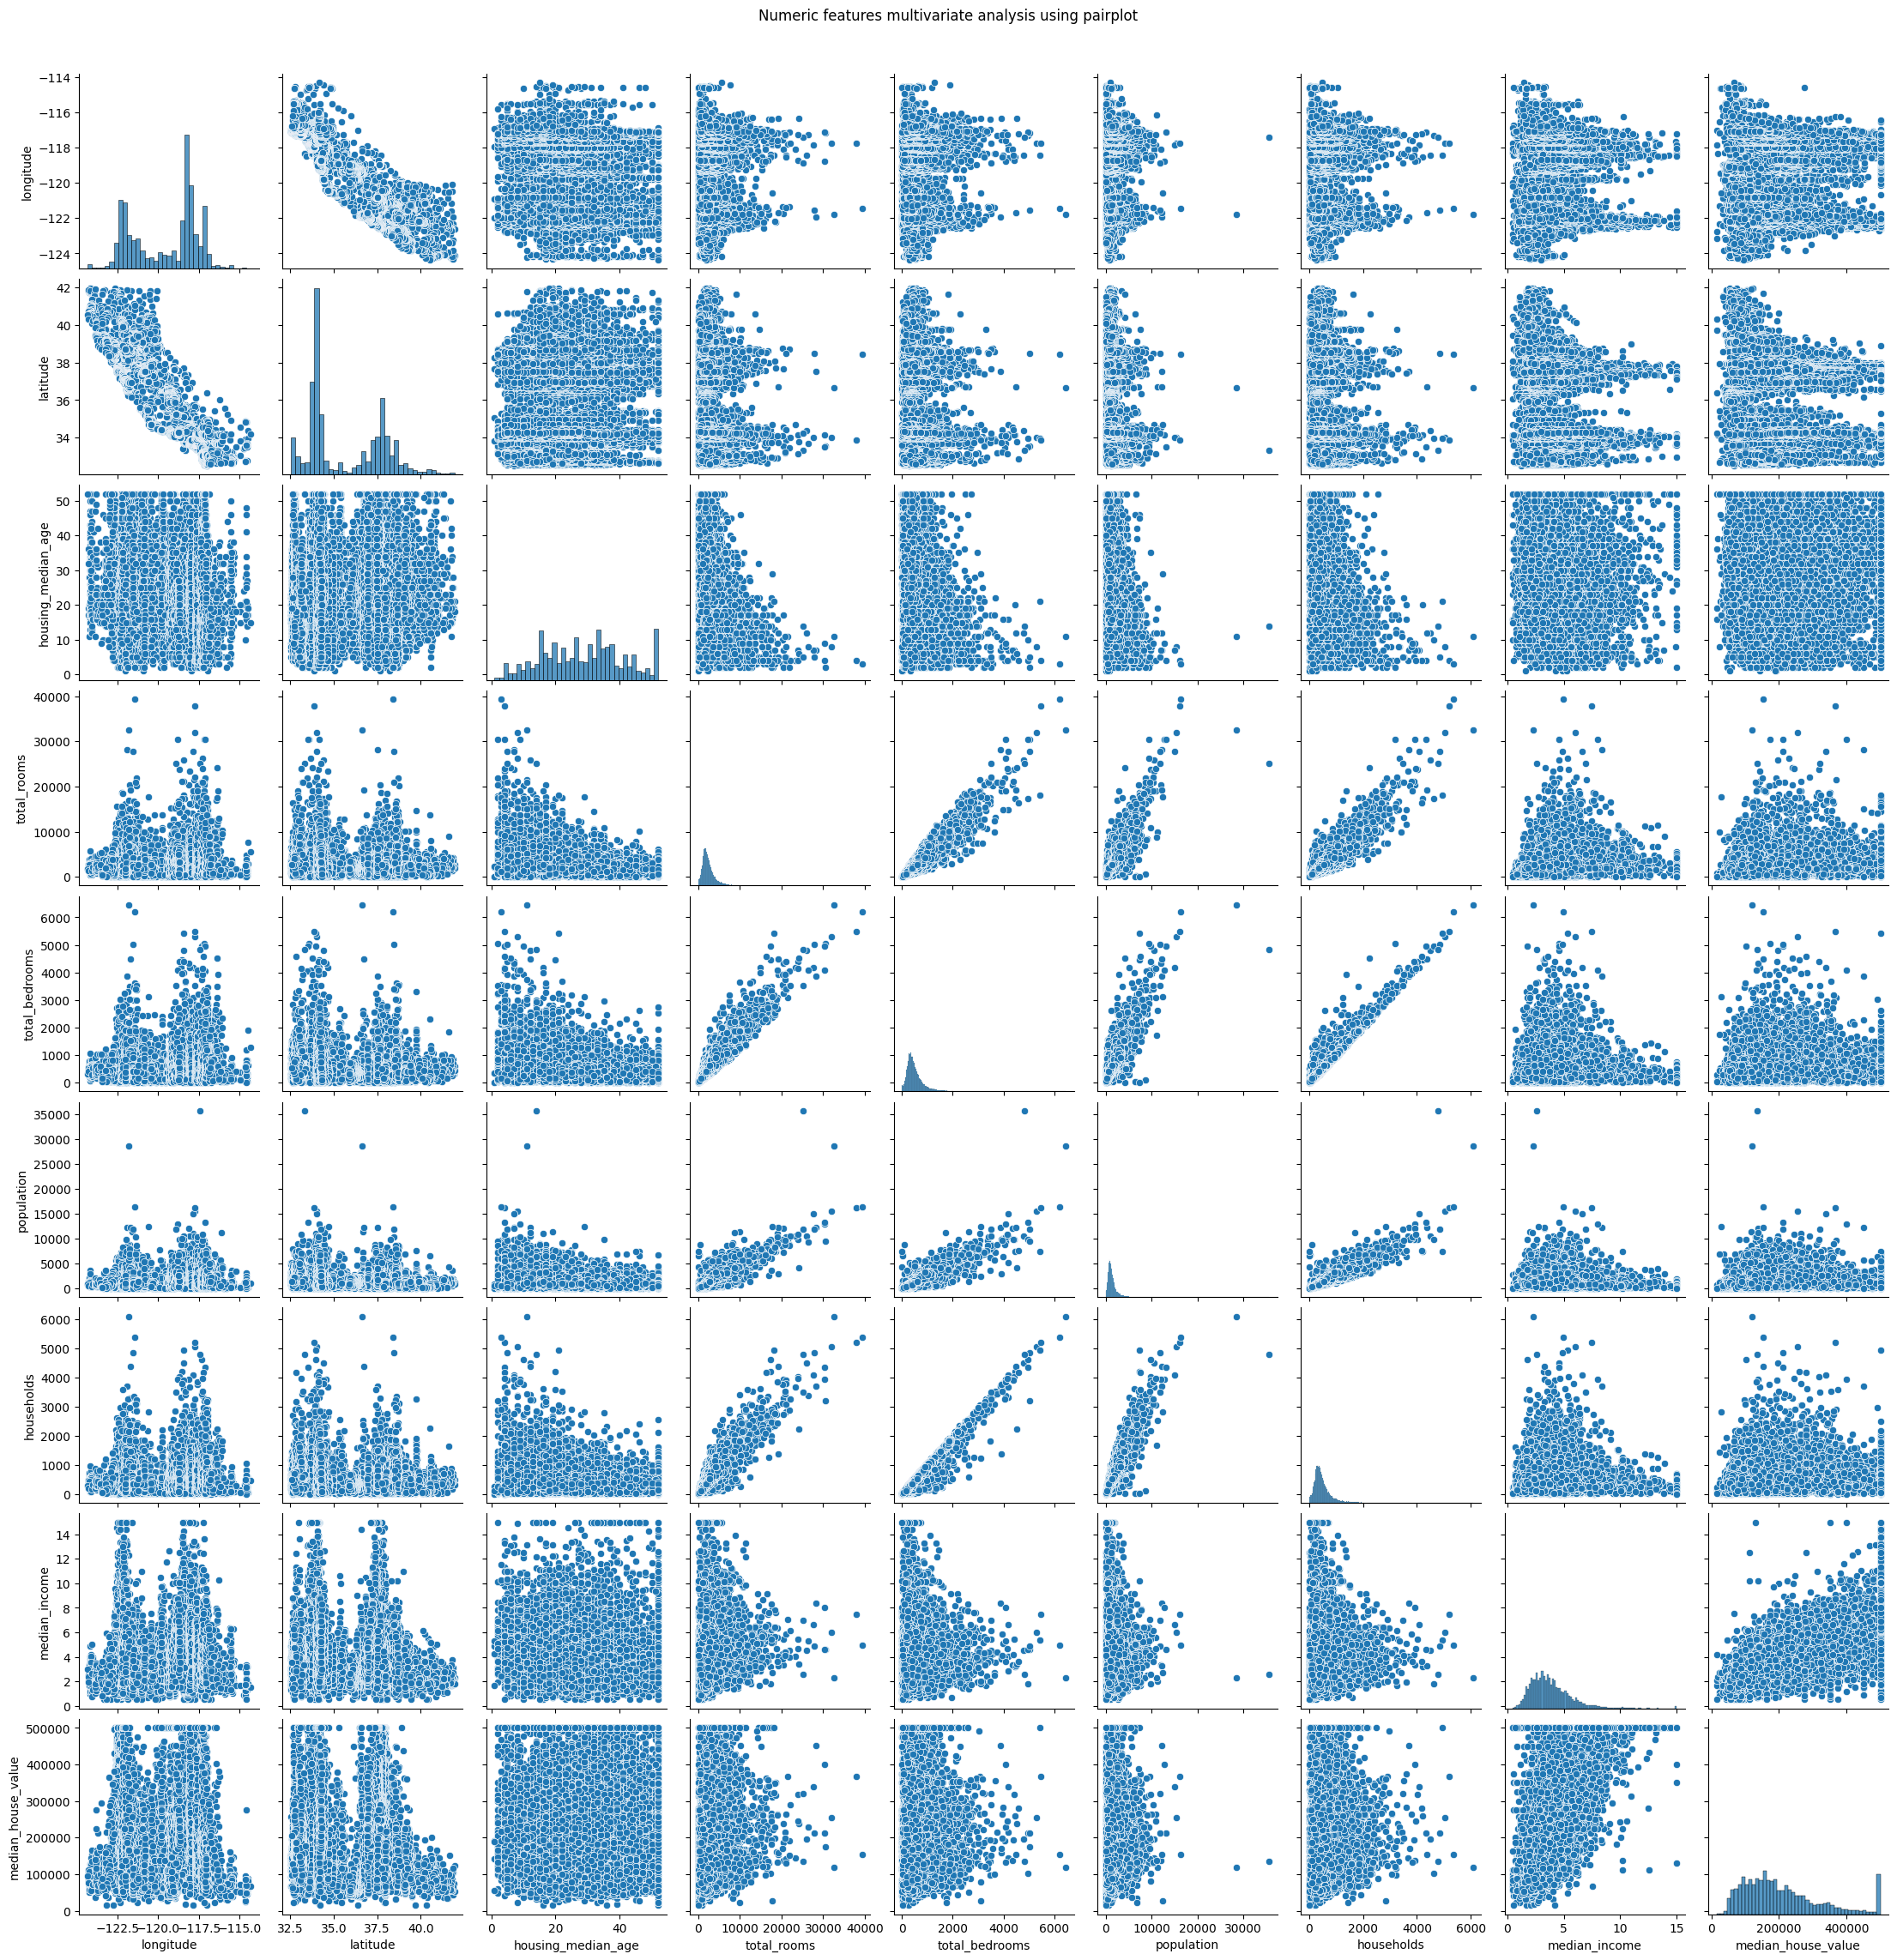

In [8]:
visualise(df_og)

#### Conclusions: 

- Majority of our houses are less than 1 hour away from ocean.
- Our data has a lot of outliers which we will have to clip
- Our data is mostly right skewed meaning most of our data has values on lower sides such as lower total rooms, lower total bedrooms etc.
- total rooms is positively correlated with number of households in an area, population in the area, total number of bedrooms as expected.
- median_house_income is somewhat correlated with our target feature median_house_value

## Data preprocessing

In [9]:
df = df_og.copy(deep=True)

### Handling null values

we have a lot of rows, so we can safely drop null values.

In [10]:
df = df.dropna()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
df.shape

(20433, 10)

### Handling outliers

In [12]:
numerical_columns = (
    df.drop("median_house_value", axis=1).select_dtypes(include="number").columns
)


for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[col] = np.clip(df[col], lower_bound, upper_bound)

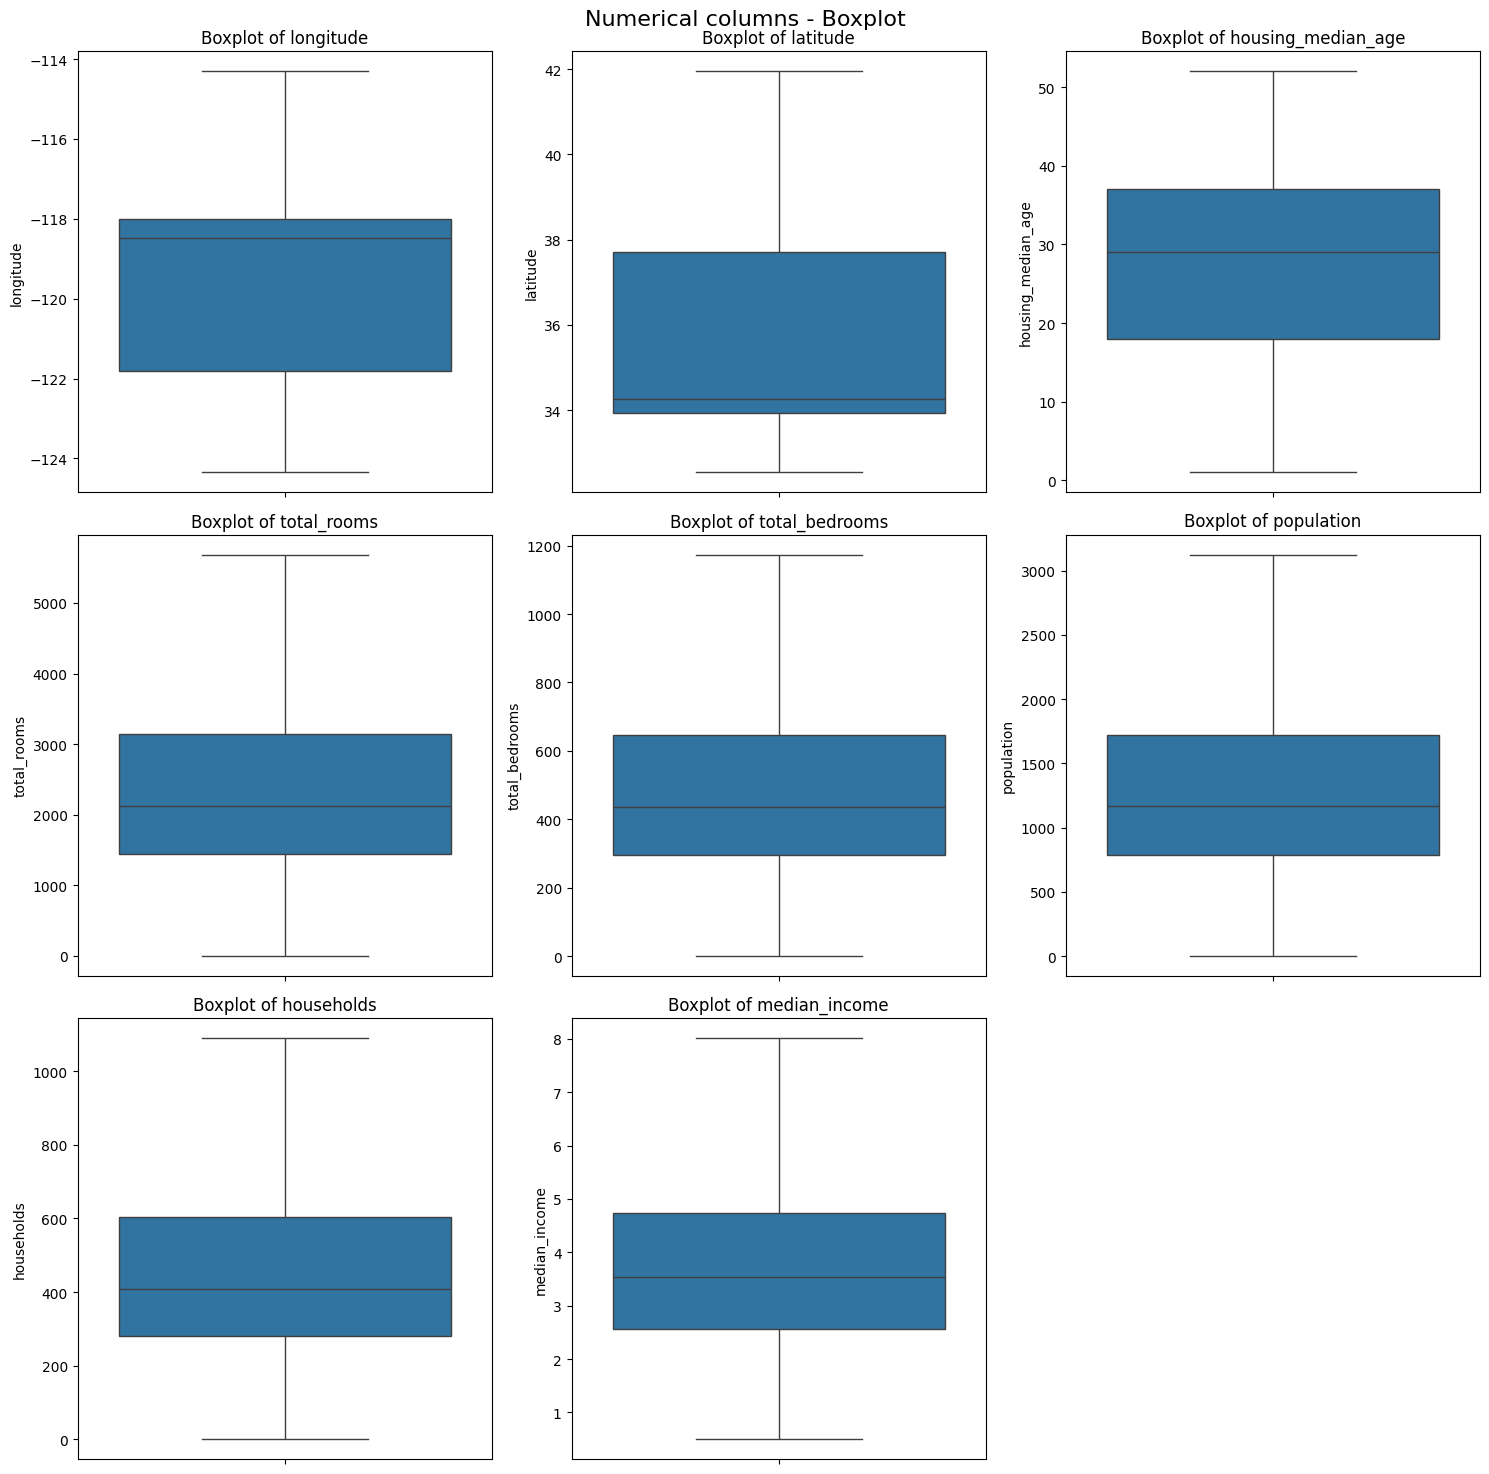

In [13]:
n_cols = 3
n_rows = math.ceil(len(numerical_columns) / n_cols)
plt.figure(figsize=(5 * n_cols, 5 * n_rows))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
plt.suptitle("Numerical columns - Boxplot", fontsize = 16)
plt.tight_layout()
plt.show()


### Encoding our categorical data

In [14]:
# One-hot encode categorical column
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)

## Feature selection 1

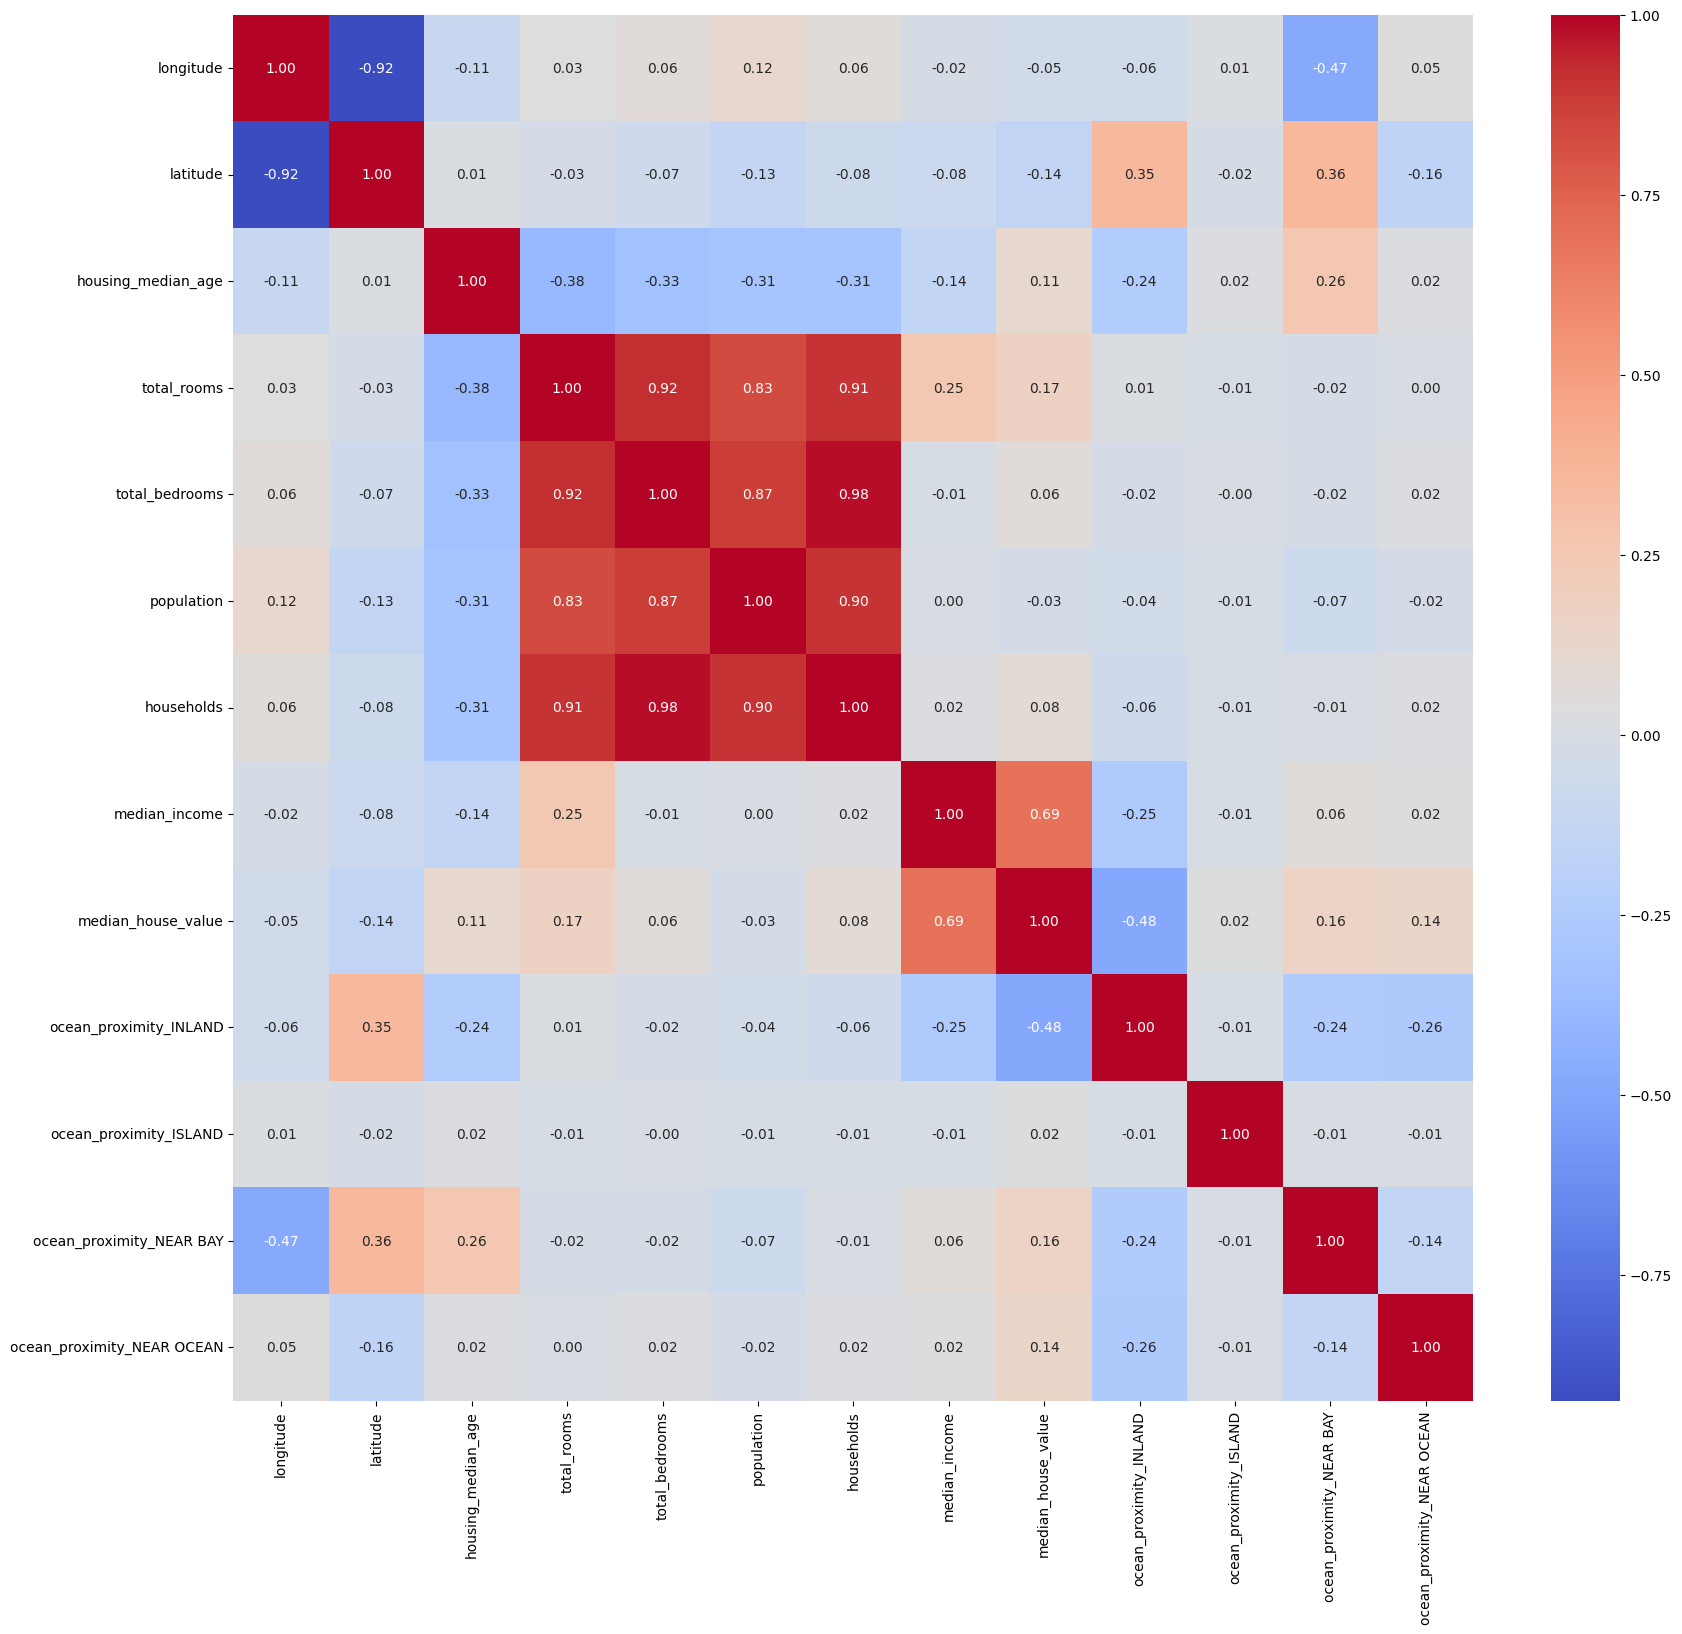

In [15]:
plt.figure(figsize=(20,18))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f', cbar=True, yticklabels=True)
plt.show()

- income is the most correlated feature with our target variable
- population is the least correlated feature with our target variable
- there are a lot of multicorrelated values so we should make new columns out of those and drop these to drop the correlation

In [16]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

In [17]:
columns_to_drop = [
    "households",
    "total_rooms",
    "total_bedrooms",
    "population"
]

df = df.drop(columns=columns_to_drop, axis=1)
df.head()

,longitude,latitude,housing_median_age,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,8.01445,452600.0,False,False,True,False,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,8.01445,358500.0,False,False,True,False,5.213303,0.194633,2.202752
2,-122.24,37.85,52.0,7.25740,352100.0,False,False,True,False,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,5.64310,341300.0,False,False,True,False,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,3.84620,342200.0,False,False,True,False,6.281853,0.172096,2.181467


IQR of our data so we can easily assess RMSE

In [18]:
q1 = df["median_house_value"].quantile(0.25)
q3 = df["median_house_value"].quantile(0.75)
iqr = q3 - q1

print(f"IQR of median_house_value: {iqr}")

IQR of median_house_value: 145200.0


divide the features into input features and output feature

In [19]:
X = df.drop("median_house_value", axis = 1)
y= df["median_house_value"]

## Data Splitting

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (16346, 11)
y_train shape: (16346,)
X_test shape: (4087, 11)
y_test shape: (4087,)


In [21]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

print("Scaling completed.")

Scaling completed.


## Model training - Base model

In [22]:
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_test_sc)
print(f"RMSE of base model Linear regression: {root_mean_squared_error(y_test, y_pred)}")
print(f"R2 of base model Linear regression: {r2_score(y_test, y_pred)}")

RMSE of base model Linear regression: 72434.69394374815
R2 of base model Linear regression: 0.6163279324192049


## Model selection

In [23]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVM': SVR()
}

for name, model in models.items():
    model.fit(X_train_sc, y_train)
    y_pred = model.predict(X_test_sc)
    print(f"{name} - RMSE: {root_mean_squared_error(y_test, y_pred)}")
    print(f"{name} - R2: {r2_score(y_test, y_pred)}\n\n")

Linear Regression - RMSE: 72434.69394374815
Linear Regression - R2: 0.6163279324192049


Decision Tree - RMSE: 68895.13370295738
Decision Tree - R2: 0.6529084681066335


Random Forest - RMSE: 50613.88042691557
Random Forest - R2: 0.812670491750749


SVM - RMSE: 119590.6433811381
SVM - R2: -0.04583056034661359




now that we do know that Random forest is best, we will make a forward selection feature selection specifically for random forest

## Feature selection 2

In [24]:
sfs = SequentialFeatureSelector(
    estimator=RandomForestRegressor(random_state=42),
    n_features_to_select="auto",
    direction="forward",
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
)

sfs.fit(X_train, y_train)

,estimator estimator: estimator instanceAn unfitted estimator.,RandomForestR...ndom_state=42)
,"n_features_to_select n_features_to_select: ""auto"", int or float, default=""auto""If `""auto""`, the behaviour depends on the `tol` parameter:- if `tol` is not `None`, then features are selected while the score change does not exceed `tol`.- otherwise, half of the features are selected.If integer, the parameter is the absolute number of features to select.If float between 0 and 1, it is the fraction of features to select... versionadded:: 1.1 The option `""auto""` was added in version 1.1... versionchanged:: 1.3 The default changed from `""warn""` to `""auto""` in 1.3.",'auto'
,"tol tol: float, default=NoneIf the score is not incremented by at least `tol` between twoconsecutive feature additions or removals, stop adding or removing.`tol` can be negative when removing features using `direction=""backward""`.`tol` is required to be strictly positive when doing forward selection.It can be useful to reduce the number of features at the cost of a smalldecrease in the score.`tol` is enabled only when `n_features_to_select` is `""auto""`... versionadded:: 1.1",None
,"direction direction: {'forward', 'backward'}, default='forward'Whether to perform forward selection or backward selection.",'forward'
,"scoring scoring: str or callable, default=NoneScoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)`` that returns a single value. See :ref:`scoring_callable` for details.- `None`: the `estimator`'s :ref:`default evaluation criterion ` is used.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. In all othercases, :class:`~sklearn.model_selection.KFold` is used. These splittersare instantiated with `shuffle=False` so the splits will be the sameacross calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel. When evaluating a new feature toadd or remove, the cross-validation procedure is parallel over thefolds.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",-1
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all l

In [25]:
selected_features = X.columns[sfs.get_support()]
print(f"Selected Columns: {selected_features}")

Selected Columns: Index(['longitude', 'latitude', 'median_income', 'ocean_proximity_NEAR OCEAN',
       'rooms_per_household'],
      dtype='object')


In [31]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print("Features reduced.")

Features reduced.


In [32]:
print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features: {X_train.shape[1]}")

Original number of features: 11
Reduced number of features: 5


now that we have the best features selected, we will tune the hyperparameters of random forest to get the optimal results

## Hyperparameter tuning

In [33]:
cv = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    scoring="neg_root_mean_squared_error",
    param_distributions={
        "n_estimators": [200, 400, 600, 800],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True],
    },
    n_iter=40,
    cv=5,
    n_jobs=-1,
    verbose=True,
)

In [34]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'bootstrap': [True], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",40
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can b

In [35]:
print(f"Best parameters: {cv.best_params_}")
print(f"Best RMSE: {abs(cv.best_score_)}")

Best parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best RMSE: 48734.66778359598


In [36]:
rf = cv.best_estimator_
rf

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'log2'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsam

In [37]:
y_pred = rf.predict(X_test)

print(f"Best RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Best R2: {r2_score(y_test, y_pred)}")

Best RMSE: 49488.44132630625
Best R2: 0.8209087058354787


## Conclusion

after hyperparameter tuning, we now have a lower RMSE and higher R2 score meaning, our error is less and variance capture has increased from 81% to 82%. this is the best result we could get for this dataset.

we can save this model for real time predictions